## <b> Introduction </b>

<b> The problem statement is that we are given a health insurance dataset with customer information on insurance charges, age, sex, BMI etc. Our task is to predict insurance charges based on these parameters in the dataset. This is a regression problem as our target variable – Charges – is numeric. </b>

## <b> Code </b>

### <b> Importing necessary libraries </b>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, stats
import seaborn as sns
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xg
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

### <b> Loading the dataset into a Dataframe </b>

In [2]:
# ignore warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("insurance.csv")
data.rename(columns = ({'expenses':'charges'}), inplace = True)
data.dropna(inplace=True)
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
charges,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


In [5]:
print("Number of null values: ")
data.isnull().sum()

Number of null values: 


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


### <b> Handling Null/Missing Values </b>

In [7]:
#Instantiate SimpleImputer 
si=SimpleImputer(missing_values = np.nan, strategy="median")
si.fit(data[['age', 'bmi']])
  
#Filling missing data with median
data[['age', 'bmi']] = si.transform(data[['age', 'bmi']])

### <b> Data Visualization </b>

<b> Visualizing our cleaned data using a simple seaborn pairplot </b>

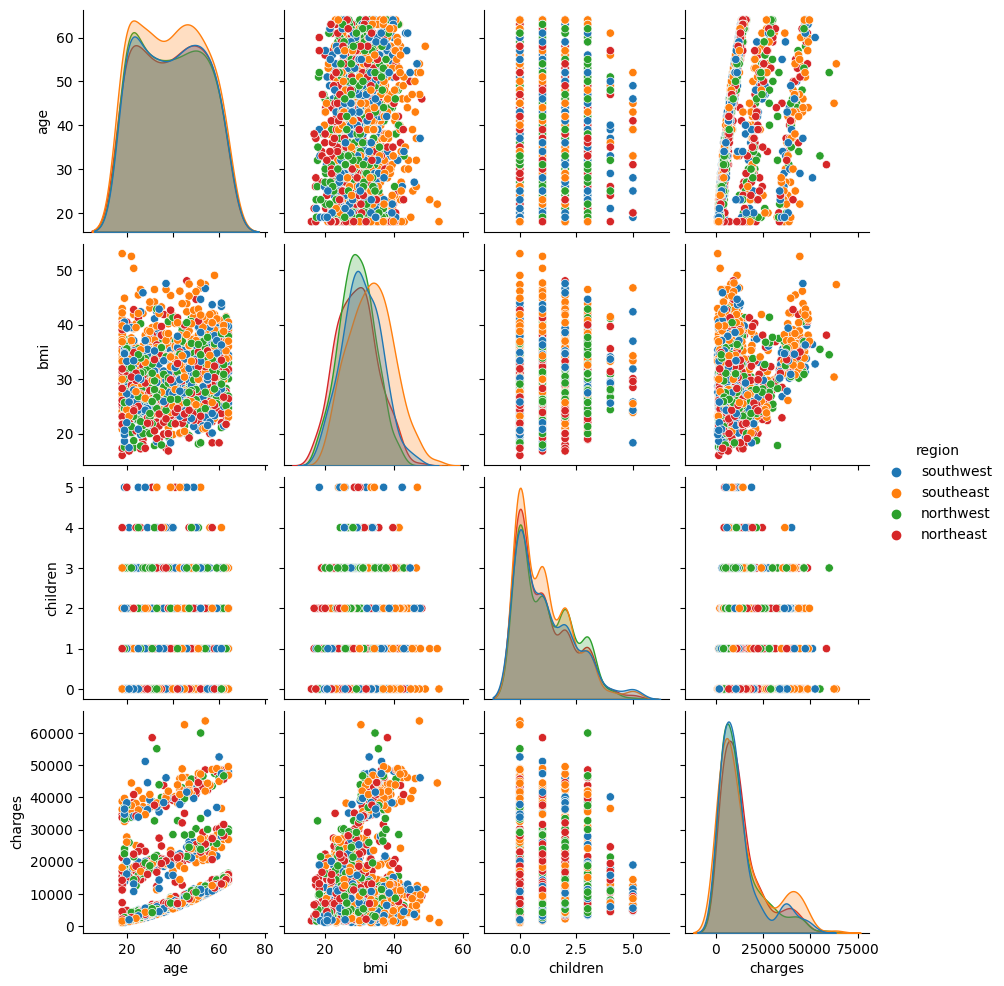

In [8]:
p = sns.pairplot(data = data, hue = "region")
p.fig.set_size_inches(10,10)

<b> Observations: 
- Charges and children are skewed.
- Age shows a positive correlation with Charges.
- BMI follows a normal distribution. </b>

In [9]:
num_lst = []
cat_lst = []

for column in data:
    if is_numeric_dtype(data[column]):
        num_lst.append(column)
    elif is_string_dtype(data[column]):
        cat_lst.append(column)
        
print("Columns with numeric values: ",num_lst)
print("Columns with string values: ",cat_lst)    

Columns with numeric values:  ['age', 'bmi', 'children', 'charges']
Columns with string values:  ['sex', 'smoker', 'region']


### <b> Plots showing the impact of categorical variables on charges </b>

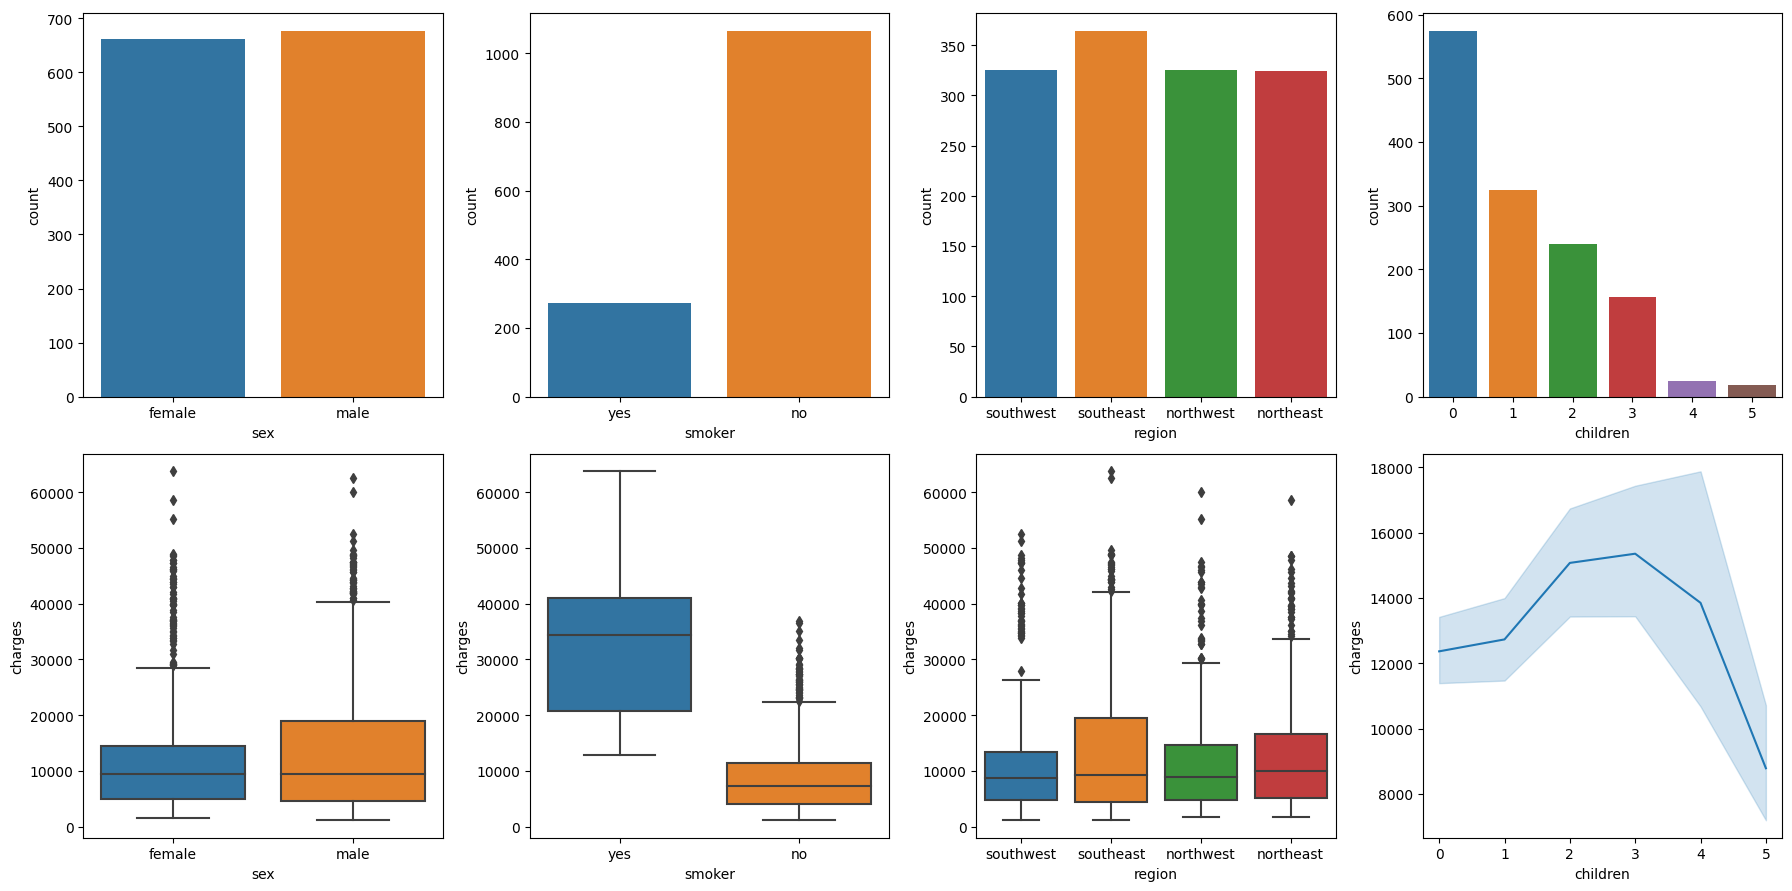

In [10]:
f, axes = plt.subplots(2,4, figsize=(18,9))
sns.countplot(ax = axes[0, 0], x = 'sex', data = data)
sns.countplot(ax = axes[0, 1], x = 'smoker', data = data)
sns.countplot(ax = axes[0, 2], x = 'region', data = data)
sns.countplot(ax = axes[0, 3], x = 'children', data = data)

sns.boxplot(ax = axes[1, 0], x = 'sex', y = 'charges', data = data)
sns.boxplot(ax = axes[1, 1], x = 'smoker', y = 'charges', data = data)
sns.boxplot(ax = axes[1, 2], x = 'region', y = 'charges', data = data)
sns.lineplot(ax = axes[1, 3], x = 'children', y = 'charges', data = data)
f.tight_layout(pad = 1.0)
plt.show()

<b> Observations based on the above plots:
- Males and females are almost equal in number and on average median charges of males and females are also the same, but males have a higher range of charges.
- Insurance charges are relatively higher for smokers.
- Charges are highest for people with 2–3 children.
- Customers are almost equally distributed across the 4 regions and all of them have almost the same charges.
- Percentage of female smokers is less than the percentage of male smokers.

#### Thus, we can conclude that ‘smoker’ has a considerable impact on the insurance charges, while gender has the least impact. </b>

### <b> Correlation Heatmap</b>

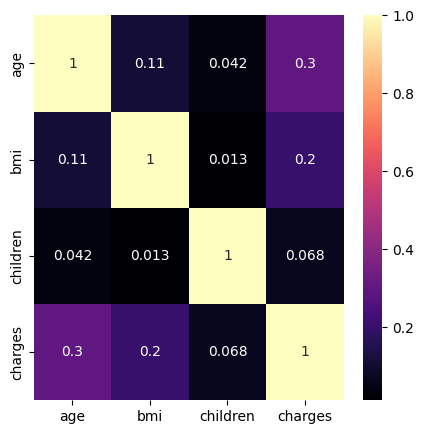

In [11]:
plt.figure(figsize=(5,5))
sns.heatmap(data.corr(), cmap="magma", annot=True)
plt.show()

In [12]:
print("Summary Statistics of Medical Costs")
print(data['charges'].describe())
print("Skew:  {}".format(skew(data['charges'])))
print("Kurtosis:  {}".format(kurtosis(data['charges'])))
print("Missing charges values: {}".format(data['charges'].isnull().sum()))
print("Missing smoker values: {}".format(data['smoker'].isnull().sum()))

Summary Statistics of Medical Costs
count     1338.000000
mean     13270.422414
std      12110.011240
min       1121.870000
25%       4740.287500
50%       9382.030000
75%      16639.915000
max      63770.430000
Name: charges, dtype: float64
Skew:  1.5141797167430497
Kurtosis:  1.5958213684180036
Missing charges values: 0
Missing smoker values: 0


### <b> Covariance matrix </b>

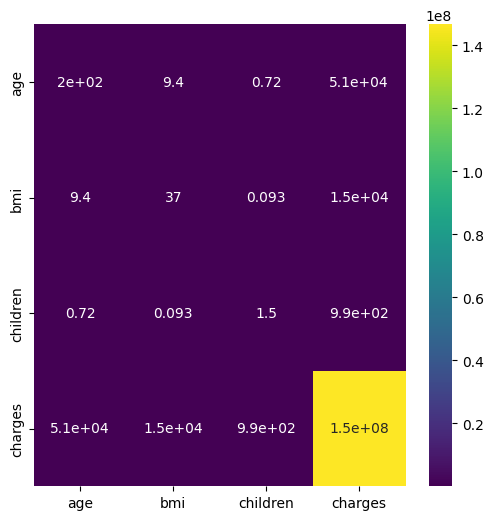

In [13]:
insur_cov = data.cov()
plt.figure(figsize=(6,6))
sns.heatmap(insur_cov, annot=True, cmap="viridis")
plt.show()

## <b> Data Preprocessing </b>
### <b> Detecting Outliers </b>
<b> Outliers are those data points that are significantly different from the rest of the dataset. They are often abnormal observations that skew the data distribution and arise due to inconsistent data entry or erroneous observations. </b>

In [14]:
def detect_outliers(data):
    for i in data.describe().columns:
        Q1 = data.describe().at['25%',i]
        Q3 = data.describe().at['75%',i]
        IQR = Q3 - Q1
        LTV = Q1 - (1.5*IQR)
        UTV = Q3 + (1.5*IQR)
        x = np.array(data[i])
        outliers = []
        for j in x:
            if j < LTV or j > UTV:
                outliers.append(j)
        # return outliers
    
        print('\n Outliers for Column : ', i, ' Outliers count ', len(outliers))
        print(outliers)

In [15]:
x = data[num_lst]
detect_outliers(x)


 Outliers for Column :  age  Outliers count  0
[]

 Outliers for Column :  bmi  Outliers count  9
[49.1, 48.1, 47.5, 47.4, 50.4, 47.6, 52.6, 47.7, 53.1]

 Outliers for Column :  children  Outliers count  0
[]

 Outliers for Column :  charges  Outliers count  139
[39611.76, 36837.47, 37701.88, 38711.0, 35585.58, 51194.56, 39774.28, 48173.36, 38709.18, 37742.58, 47496.49, 37165.16, 39836.52, 43578.94, 47291.06, 47055.53, 39556.49, 40720.55, 36950.26, 36149.48, 48824.45, 43753.34, 37133.9, 34779.62, 38511.63, 35160.13, 47305.31, 44260.75, 41097.16, 43921.18, 36219.41, 46151.12, 42856.84, 48549.18, 47896.79, 42112.24, 38746.36, 42124.52, 34838.87, 35491.64, 42760.5, 47928.03, 48517.56, 41919.1, 36085.22, 38126.25, 42303.69, 46889.26, 46599.11, 39125.33, 37079.37, 35147.53, 48885.14, 36197.7, 38245.59, 48675.52, 63770.43, 45863.21, 39983.43, 45702.02, 58571.07, 43943.88, 39241.44, 42969.85, 40182.25, 34617.84, 42983.46, 42560.43, 40003.33, 45710.21, 46200.99, 46130.53, 40103.89, 34806.47, 

In [16]:
data.nunique()

age           47
sex            2
bmi          275
children       6
smoker         2
region         4
charges     1337
dtype: int64

### <b> One-hot encoding </b>
<b> One hot encoding is one method of converting data to prepare it for an algorithm and get a better prediction. In one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector. </b>

In [17]:
region = pd.get_dummies(data.region, prefix = 'location')
df = pd.concat([data, region],axis = 1)
df.drop(columns='region', inplace=True)

In [18]:
df.smoker.replace({'yes':1, 'no':0}, inplace=True)
df.sex.replace({'male':1, 'female':0}, inplace=True)
df.head()

,age,sex,bmi,children,smoker,charges,location_northeast,location_northwest,location_southeast,location_southwest
0,19.0,0,27.9,0,1,16884.92,0,0,0,1
1,18.0,1,33.8,1,0,1725.55,0,0,1,0
2,28.0,1,33.0,3,0,4449.46,0,0,1,0
3,33.0,1,22.7,0,0,21984.47,0,1,0,0
4,32.0,1,28.9,0,0,3866.86,0,1,0,0


### <b> Feature Selection and Scaling </b>
<b> Next, we will select features that affect 'charges' the most. These features will form our 'X' variable while charges will be our 'Y' variable. </b>

In [19]:
Y = df.charges.values
X = df[['age', 'bmi', 'smoker', 'children', 'location_northeast', 'location_northwest', 'location_southeast', 'location_southwest']]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42, test_size=0.20)

### <b> Standard Scaling </b>

##### <b> Standardizing the features by removing the mean and scaling it to unit variance. </b>  

In [20]:
numeric = ['age', 'bmi', 'children']
sc = StandardScaler()
X_train[numeric] = sc.fit_transform(X_train[numeric])   
X_test[numeric] = sc.transform(X_test[numeric])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 1338 non-null   float64
 1   sex                 1338 non-null   int64  
 2   bmi                 1338 non-null   float64
 3   children            1338 non-null   int64  
 4   smoker              1338 non-null   int64  
 5   charges             1338 non-null   float64
 6   location_northeast  1338 non-null   uint8  
 7   location_northwest  1338 non-null   uint8  
 8   location_southeast  1338 non-null   uint8  
 9   location_southwest  1338 non-null   uint8  
dtypes: float64(3), int64(3), uint8(4)
memory usage: 68.1 KB


### <b> Saving changes to a new dataset </b>

In [22]:
df.to_csv('Insurance_new.csv', index = False)

### <b> Different Regression Models</b>
<b> I have used 4 regression models and have obtained the following results.

In [23]:
lir = LinearRegression()
lir.fit(X_train,Y_train)
ypred_lir = lir.predict(X_test)

rr = Ridge()
rr.fit(X_train,Y_train)
ypred_rr = rr.predict(X_test)

dtr = DecisionTreeRegressor()
dtr.fit(X_train,Y_train)
ypred_dtr = dtr.predict(X_test)

rfr = RandomForestRegressor()
rfr.fit(X_train,Y_train)
ypred_rfr = rfr.predict(X_test)

scores1 = {'Model': ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'RandomForest'],
           'R2 Score': [r2_score(Y_test,ypred_lir), r2_score(Y_test,ypred_rr), r2_score(Y_test,ypred_dtr), r2_score(Y_test,ypred_rfr)],
           'MAE': [mean_absolute_error(Y_test, ypred_lir), mean_absolute_error(Y_test, ypred_rr), mean_absolute_error(Y_test, ypred_dtr), mean_absolute_error(Y_test, ypred_rfr)],
           'RMSE': [np.sqrt(mean_squared_error(Y_test, ypred_lir)), np.sqrt(mean_squared_error(Y_test, ypred_rr)), np.sqrt(mean_squared_error(Y_test, ypred_dtr)), np.sqrt(mean_squared_error(Y_test, ypred_rfr))],
           }
df1 = pd.DataFrame(scores1)
df1.head()

,Model,R2 Score,MAE,RMSE
0,Linear Regression,0.783537,4182.375783,5797.036996
1,Ridge Regression,0.783254,4193.749405,5800.826858
2,Decision Tree,0.752885,2901.910448,6193.896547
3,RandomForest,0.865989,2483.663283,4561.261721


### <b> Feature Engineering </b>

<b> We can improve our model score by manipulating some of the features in the dataset. Here, I have implemented the following:

- Grouping similar customers into clusters using KMeans.
- Clubbing northeast and northwest regions into 'north' and southeast and southwest into 'south' in Region column.
- Transforming 'children' into a categorical feature called 'more_than_one_child' which is 'Yes' if the number of children is > 1

In [24]:
features = ['age', 'bmi', 'smoker', 'children', 'location_northeast', 'location_northwest', 'location_southeast', 'location_southwest']
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[features])

df['cust_type'] = kmeans.predict(df[features])

df['location_north'] = df.apply(lambda x: (x['location_northeast'] or x['location_northwest']), axis=1)
df['location_south'] = df.apply(lambda x: (x['location_southeast'] or x['location_southwest']),axis=1)

df['more_than_1_child'] = df.children.apply(lambda x:1 if x>1 else 0)

df.drop(columns=['location_northeast', 'location_northwest', 'location_southeast', 'location_southwest'], inplace=True)

df.head()

,age,sex,bmi,children,smoker,charges,cust_type,location_north,location_south,more_than_1_child
0,19.0,0,27.9,0,1,16884.92,0,0.0,1.0,0
1,18.0,1,33.8,1,0,1725.55,0,0.0,1.0,0
2,28.0,1,33.0,3,0,4449.46,0,0.0,1.0,1
3,33.0,1,22.7,0,0,21984.47,0,1.0,0.0,0
4,32.0,1,28.9,0,0,3866.86,0,1.0,0.0,0


### <b> Feature Transformation </b>
<b> We have seen that the distribution of 'charges(Y)' is highly skewed and hence I have applied 'QuantileTransformer' to normalize this behavior.

In [25]:
X = df[['age', 'bmi', 'smoker', 'more_than_1_child', 'cust_type', 'location_north', 'location_south']]
#Split test and train data
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.2, random_state=42)

lir = LinearRegression()
regr_trans1 = TransformedTargetRegressor(regressor=lir, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans1.fit(X_train,Y_train)
ypred_lir = regr_trans1.predict(X_test)

rr = Ridge()
regr_trans3 = TransformedTargetRegressor(regressor=rr, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans3.fit(X_train,Y_train)
ypred_rr = regr_trans3.predict(X_test)

dtr = DecisionTreeRegressor()
regr_trans4 = TransformedTargetRegressor(regressor=dtr, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans4.fit(X_train,Y_train)
ypred_dtr = regr_trans4.predict(X_test)

rfr = RandomForestRegressor()
regr_trans5 = TransformedTargetRegressor(regressor=rfr, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans5.fit(X_train,Y_train)
ypred_rfr = regr_trans5.predict(X_test)

scores1 = {'Model': ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'Random Forest'],
           'R2 Score': [r2_score(Y_test,ypred_lir), r2_score(Y_test,ypred_rr), r2_score(Y_test,ypred_dtr), r2_score(Y_test,ypred_rfr)],
           'MAE': [mean_absolute_error(Y_test, ypred_lir), mean_absolute_error(Y_test, ypred_rr), mean_absolute_error(Y_test, ypred_dtr), mean_absolute_error(Y_test, ypred_rfr)],
           'RMSE': [np.sqrt(mean_squared_error(Y_test, ypred_lir)), np.sqrt(mean_squared_error(Y_test, ypred_rr)), np.sqrt(mean_squared_error(Y_test, ypred_dtr)), np.sqrt(mean_squared_error(Y_test, ypred_rfr))],
           }
df1 = pd.DataFrame(scores1)
df1.head()

,Model,R2 Score,MAE,RMSE
0,Linear Regression,0.732223,3280.426681,6447.637002
1,Ridge Regression,0.732019,3290.970609,6450.091928
2,Decision Tree,0.844716,2164.722023,4909.949489
3,Random Forest,0.881601,2053.326915,4287.346485


### <b> Boosting Algorithms </b>
<b> Boosting is a method used in machine learning to reduce errors in predictive data analysis.

### <b> Performance plots of all the above performed models </b>

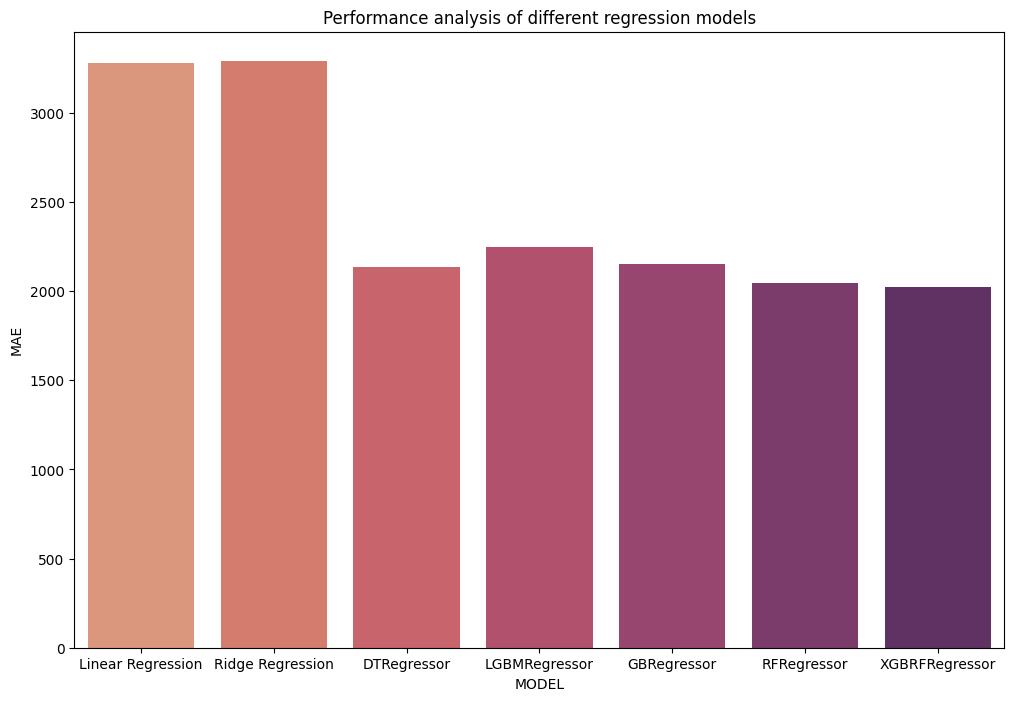

,Model,Score,MAE,RMSE
0,LinearRegression,0.732,3280.43,6447.64
1,Ridge,0.732,3290.97,6450.09
2,DecisionTreeRegressor,0.848,2133.65,4860.04
3,LGBMRegressor,0.866,2247.33,4564.82
4,GradientBoostingRegressor,0.874,2150.56,4418.47
5,RandomForestRegressor,0.884,2024.87,4249.41
6,XGBRFRegressor,0.881,2022.56,4298.76


In [58]:
#generic function to fit model and return metrics for every algorithm
def boost_models(x):
    #transforming target variable through quantile transformer
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, Y_train)
    yhat = regr_trans.predict(X_test)
    algoname= x.__class__.__name__
    
    return algoname, round(r2_score(Y_test, yhat),3), round(mean_absolute_error(Y_test, yhat),2), round(np.sqrt(mean_squared_error(Y_test, yhat)),2)
    
def plot(x):
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, Y_train)
    yhat = regr_trans.predict(X_test)
    algoname= x.__class__.__name__
    
    plt.figure(figsize=(3,3))
    sns.regplot(x = Y_test, y = yhat, label=algoname, color = 'y', marker = '.', line_kws={'color': 'red'})
    plt.title(algoname)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    

algo=[LinearRegression(), Ridge(), DecisionTreeRegressor(), lgb.LGBMRegressor(), GradientBoostingRegressor(), RandomForestRegressor(), xg.XGBRFRegressor()]
MAE = []
score = []
for a in algo:
    MAE.append(boost_models(a)[2])
    score.append(boost_models(a))
    
dataPerf = pd.DataFrame(data={'MODEL': ['Linear Regression', 'Ridge Regression', 'DTRegressor', 'LGBMRegressor', 'GBRegressor', 'RFRegressor', 'XGBRFRegressor'], 'MAE': MAE})

plt.figure(figsize=(12, 8))
sns.barplot(x="MODEL", y="MAE", data=dataPerf, palette='flare')
plt.title('Performance analysis of different regression models')
plt.show()
 #Collate all scores in a table
pd.DataFrame(score, columns=['Model', 'Score', 'MAE', 'RMSE'])

<h5 align="right"> <b> Submitted by:- <br> 
Name: S.Hariharasubramaniam <br>
Roll No: AM.EN.U4AIE21156 </b> </h5>